In [1]:
import sys
 
sys.path.insert(0, "../")

In [2]:
from dataAnalysis.DataAnalysis import DataAnalysis
import pandas as pd
import cudf
import torch

data = pd.read_csv(r"../extdata/sbcdata.csv", header=0)
data_analysis = DataAnalysis(data)

/home/dwalke/git/sbc/graph_learning/../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Training: 
Assessable data are 528101 cases and 1015074 CBCs
Control data are 527038 cases and 1013548 CBCs
Sepsis data are 1488 cases and 1526 CBCs
$$$$$$$$$$$$$$$$$$$$
Testing: 


/home/dwalke/git/sbc/graph_learning/../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Controls: 365794, Sepsis: 490
Assessable data are 180494 cases and 366284 CBCs
Control data are 180157 cases and 365794 CBCs
Sepsis data are 472 cases and 490 CBCs


/home/dwalke/git/sbc/graph_learning/../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Controls: 437629, Sepsis: 448
Assessable data are 157922 cases and 438077 CBCs
Control data are 180157 cases and 437629 CBCs
Sepsis data are 438 cases and 448 CBCs


In [3]:
data = pd.concat((data_analysis.get_training_data(), data_analysis.get_testing_data()))
max_Id = data["Id"].unique().max()
gw_data = data_analysis.get_gw_testing_data().copy(deep=True)
gw_data = gw_data.assign(Id=lambda x: x.Id + max_Id)
data = pd.concat((data, gw_data))
data = data.sort_values("Id")
unique_ids = data["Id"].unique()
data = data.reset_index(drop=True)
data.pop("index")
data = data.sort_values(["Id", "Time"])
data = data.reset_index(drop=True)

In [4]:
from dataAnalysis.Constants import SEX_CATEGORY_COLUMN_NAME, SEX_COLUMN_NAME, FEATURES
data[SEX_CATEGORY_COLUMN_NAME] = data.loc[:, SEX_COLUMN_NAME] =="W"
data[SEX_CATEGORY_COLUMN_NAME] = data[SEX_CATEGORY_COLUMN_NAME].astype("int8")
data["Label"] = data["Label"] == "Sepsis"
data["Label"] = data["Label"].astype("int8")

In [5]:
X_features = torch.tensor(data[FEATURES].values).type(torch.float32)
y = torch.tensor(data["Label"].values).type(torch.long)

In [6]:
from dataAnalysis.FeatureImportance import normalize

X_features = normalize(X_features)

In [7]:
import torch
edge_index = torch.tensor(pd.read_csv("dir_edge_index_sorted_ids_w_gw_corr.csv", header=None, skiprows=1).values.transpose(), dtype=torch.long)

In [8]:
from torch_geometric.data import Data
import numpy as np

def ratio_bool_switch(tensor, ratio = 0.8):
    random = np.random.uniform(0, 1 ,tensor.shape[0])
    val_ratio_mask = (random >= ratio)
    train_ratio_mask = (random < ratio)
    val_mask = np.logical_and(tensor.tolist(), val_ratio_mask.tolist())
    train_mask = np.logical_and(tensor.tolist(), train_ratio_mask.tolist())
    return torch.from_numpy(train_mask).type(torch.bool), torch.from_numpy(val_mask).type(torch.bool)

train_mask_ser = data["Set"] != "Validation"
train_mask, val_mask = ratio_bool_switch(train_mask_ser.values)
test_mask = torch.from_numpy(np.logical_and((data["Set"] == "Validation").values, (data["Center"] == "Leipzig").values)).type(torch.bool)
test_gw_mask = torch.from_numpy(np.logical_and((data["Set"] == "Validation").values, (data["Center"] == "Greifswald").values)).type(torch.bool)

In [9]:
graph = Data(x=X_features, train_mask = train_mask, test_mask=test_mask, val_mask=val_mask, y= y, edge_index=edge_index,
             test_gw_mask = test_gw_mask)

In [10]:
graph.edge_index.shape

torch.Size([2, 7259211])

In [11]:
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv,GATv2Conv, GINConv, global_add_pool
from torch.nn import Linear
import torch
from dataAnalysis.Constants import FEATURES
from torch.nn import Linear, ReLU, Sequential
from torch.nn import BatchNorm1d as BatchNorm

class GraphNeuralNetwork(torch.nn.Module):
    def __init__(self, hidden_dim = 128, out_channels = 1):
        super(GraphNeuralNetwork, self).__init__()
        input_dim = len(FEATURES)      
        
        HEADS = 5
        
        conv_1= GATConv(input_dim, hidden_dim,heads=HEADS, add_self_loops = False)
        conv_end = GATConv((-1,-1), out_channels,add_self_loops = False)
        
        self.conv_1 = conv_1
        self.conv_end = conv_end
        

    def forward(self, graph):
        x, edge_index = graph.x, graph.edge_index
        x = x.type(torch.float)
        x, attention_w_1 = self.conv_1(x, edge_index, return_attention_weights = True)
        x = F.normalize(x, p=2., dim=-1)
        x = torch.relu(x)
        x, attention_w_2 = self.conv_end(x, edge_index, return_attention_weights = True)
        return x, (attention_w_1, attention_w_2)
            
    def predict_proba(self, graph, mask):
        with torch.inference_mode():
            self.eval()
            logits = self.forward(graph)
            scores = torch.sigmoid(torch.squeeze(logits[mask]))
            scores = torch.unsqueeze(scores, 0)
            proba_predict = torch.concat((1- scores, scores), dim = 0)
            return torch.transpose(proba_predict, 0, 1)
            
    def predict(self, graph, mask):
        return torch.round(self.predict_proba(graph, mask)[:, 1])

In [12]:
model = GraphNeuralNetwork().cpu() #.to(device)
model.load_state_dict(torch.load("../models/directed_gat_wo_pos.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

In [13]:
with torch.inference_mode():
    model.eval()
    logits, (attention_w) = model(graph)
    scores = torch.sigmoid(torch.squeeze(logits))
    scores = torch.unsqueeze(scores, 0)
    proba_predict = torch.concat((1- scores, scores), dim = 0)
    pred = torch.round(scores)

In [14]:
edge_df = pd.DataFrame(graph.edge_index.t(), columns = ["source", "target"])
edge_df["attention_weights"] = attention_w[1][1]
for i in range(5):
    edge_df[f"attention_weights_{i}"] = attention_w[0][1][:, i]
edge_df[f"attention_weights_mean"] = torch.mean(attention_w[0][1], dim = 1)

In [15]:
edge_df

,source,target,attention_weights,attention_weights_0,attention_weights_1,attention_weights_2,attention_weights_3,attention_weights_4,attention_weights_mean
0,0,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,2,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,3,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,4,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...
7259206,1819430,1819432,0.247858,0.002231,0.013981,0.027458,0.261436,0.072461,0.075513
7259207,1819431,1819432,0.271116,0.001048,0.035959,0.065645,0.185199,0.056103,0.068791
7259208,1819433,1819433,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7259209,1819434,1819434,0.372705,0.519647,0.732686,0.866811,0.345808,0.310295,0.555049


In [16]:
edge_df["source_label"] = data["Label"].iloc[edge_df["source"]].reset_index(drop=True)
edge_df["target_label"] = data["Label"].iloc[edge_df["target"]].reset_index(drop=True)

## Sepsis as source label vs target label (sepsis low in-degree)

In [17]:
(edge_df["source_label"] == 1).sum(), (edge_df["target_label"] == 1).sum()

(2533, 13224)

## Attention weights

In [41]:
attention_weights_df = pd.DataFrame()
pd.options.display.float_format = '{:,.3f}'.format
attention_weights_df["Control to Control"] = edge_df[np.logical_and(edge_df["target_label"] == 0, edge_df["source_label"] == 0)]["attention_weights"].describe()
attention_weights_df["Sepsis to Control"] = edge_df[np.logical_and(edge_df["target_label"] == 0, edge_df["source_label"] == 1)]["attention_weights"].describe()
attention_weights_df["Control to Sepsis"] = edge_df[np.logical_and(edge_df["target_label"] == 1, edge_df["source_label"] == 0)]["attention_weights"].describe()
attention_weights_df["Sepsis to Sepsis"] = edge_df[np.logical_and(edge_df["target_label"] == 1, edge_df["source_label"] == 1)]["attention_weights"].describe()
attention_weights_df

,Control to Control,Sepsis to Control,Control to Sepsis,Sepsis to Sepsis
count,"7,245,987.000",0.000,"10,691.000","2,533.000"
mean,0.251,NaN,0.054,0.747
std,0.317,NaN,0.089,0.372
min,0.000,NaN,0.000,0.000
25%,0.035,NaN,0.008,0.381
50%,0.110,NaN,0.020,1.000
75%,0.318,NaN,0.058,1.000
max,1.000,NaN,0.987,1.000


## 1st  Attention heads

In [42]:
from IPython.core.display import display, HTML

for i in range(5):
    attention_weights_first_head_df = pd.DataFrame()
    pd.options.display.float_format = '{:,.3f}'.format
    for target_label in range(2):
        for source_label in range(2):
            column = f"From {'Sepsis' if source_label else 'Control'} to {'Sepsis' if target_label else 'Control'}"
            attention_weights_first_head_df[column] = edge_df[np.logical_and(edge_df["target_label"] == target_label, edge_df["source_label"] == source_label)][f"attention_weights_{i}"].describe()
    display(HTML(attention_weights_first_head_df.to_html()))

/tmp/ipykernel_14559/1401547245.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


,From Control to Control,From Sepsis to Control,From Control to Sepsis,From Sepsis to Sepsis
count,"7,245,987.000",0.000,"10,691.000","2,533.000"
mean,0.251,NaN,0.056,0.735
std,0.359,NaN,0.144,0.409
min,0.000,NaN,0.000,0.000
25%,0.003,NaN,0.001,0.331
50%,0.048,NaN,0.007,1.000
75%,0.367,NaN,0.033,1.000
max,1.000,NaN,1.000,1.000


,From Control to Control,From Sepsis to Control,From Control to Sepsis,From Sepsis to Sepsis
count,"7,245,987.000",0.000,"10,691.000","2,533.000"
mean,0.251,NaN,0.058,0.726
std,0.349,NaN,0.142,0.405
min,0.000,NaN,0.000,0.000
25%,0.013,NaN,0.005,0.285
50%,0.063,NaN,0.013,1.000
75%,0.347,NaN,0.039,1.000
max,1.000,NaN,1.000,1.000


,From Control to Control,From Sepsis to Control,From Control to Sepsis,From Sepsis to Sepsis
count,"7,245,987.000",0.000,"10,691.000","2,533.000"
mean,0.251,NaN,0.060,0.721
std,0.340,NaN,0.125,0.402
min,0.000,NaN,0.000,0.000
25%,0.017,NaN,0.006,0.281
50%,0.075,NaN,0.016,1.000
75%,0.345,NaN,0.047,1.000
max,1.000,NaN,0.994,1.000


,From Control to Control,From Sepsis to Control,From Control to Sepsis,From Sepsis to Sepsis
count,"7,245,987.000",0.000,"10,691.000","2,533.000"
mean,0.251,NaN,0.059,0.722
std,0.347,NaN,0.144,0.408
min,0.000,NaN,0.000,0.000
25%,0.007,NaN,0.001,0.293
50%,0.064,NaN,0.005,1.000
75%,0.363,NaN,0.037,1.000
max,1.000,NaN,1.000,1.000


,From Control to Control,From Sepsis to Control,From Control to Sepsis,From Sepsis to Sepsis
count,"7,245,987.000",0.000,"10,691.000","2,533.000"
mean,0.251,NaN,0.054,0.746
std,0.354,NaN,0.151,0.404
min,0.000,NaN,0.000,0.000
25%,0.003,NaN,0.000,0.417
50%,0.052,NaN,0.003,1.000
75%,0.374,NaN,0.025,1.000
max,1.000,NaN,1.000,1.000


## Averaged first attention heads

In [301]:
for target_label in range(2):
    for source_label in range(2):
        print(f"From {'Sepsis' if source_label else 'Control'} to {'Sepsis' if target_label else 'Control'}")
        print(edge_df[np.logical_and(edge_df["target_label"] == target_label, edge_df["source_label"] == source_label)][f"attention_weights_mean"].describe())

From Control to Control
count    7.245987e+06
mean     2.504969e-01
std      3.267321e-01
min      0.000000e+00
25%      1.712762e-05
50%      1.407672e-01
75%      3.996121e-01
max      1.000000e+00
Name: attention_weights_mean, dtype: float64
From Sepsis to Control
count    1.069100e+04
mean     1.752376e-01
std      1.884073e-01
min      1.165551e-31
25%      4.882324e-05
50%      1.832050e-01
75%      2.721832e-01
max      8.000000e-01
Name: attention_weights_mean, dtype: float64
From Control to Sepsis
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: attention_weights_mean, dtype: float64
From Sepsis to Sepsis
count    2533.000000
mean        0.972760
std         0.117819
min         0.141482
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: attention_weights_mean, dtype: float64


In [269]:
edge_df[edge_df["source_label"] == 1]["attention_weights"].describe()

count    1.322400e+04
mean     1.869938e-01
std      3.893807e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.903368e-39
max      1.000000e+00
Name: attention_weights, dtype: float64

In [193]:
pred.squeeze()

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [194]:
data["pred"] = pred.squeeze()

In [197]:
correct_data = data[data["pred"] == data["Label"]]

In [46]:
pd.DataFrame(torch.std(attention_w[0][1], dim = 1).numpy()).describe()

,0
count,1.269899e+07
mean,1.525897e-01
std,2.103486e-01
min,0.000000e+00
25%,3.013179e-09
50%,4.899285e-04
75%,4.266820e-01
max,5.477226e-01


In [38]:
graph.edge_index.shape

torch.Size([2, 12698987])

In [199]:
# sepsis_mask = data["Label"] == 1
# sepsis_data = data[sepsis_mask]
# sepsis_ids = sepsis_data["Id"].unique()
# data_containing_sepsis_mask = data["Id"].isin(sepsis_ids)
# data_containing_sepsis = data[data_containing_sepsis_mask]
# data_containing_sepsis = data_containing_sepsis.sort_values(["Id", "Time"])
# data_containing_sepsis = data_containing_sepsis.reset_index(drop=True)

In [210]:
un, c = np.unique(correct_data["Id"], return_counts=True)
un[c != 1].shape

(293921,)

/tmp/ipykernel_10661/1779307904.py:26: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for Id, group in data.groupby(["Id"]):


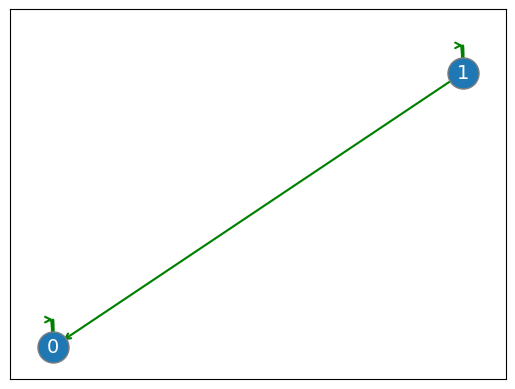

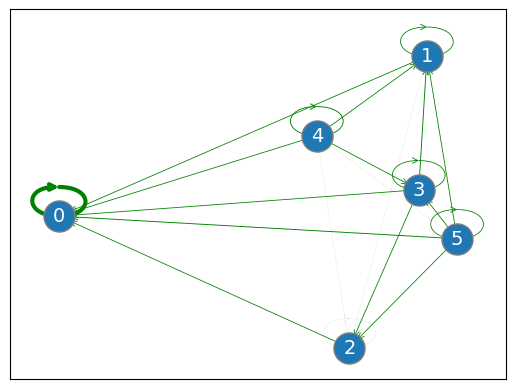

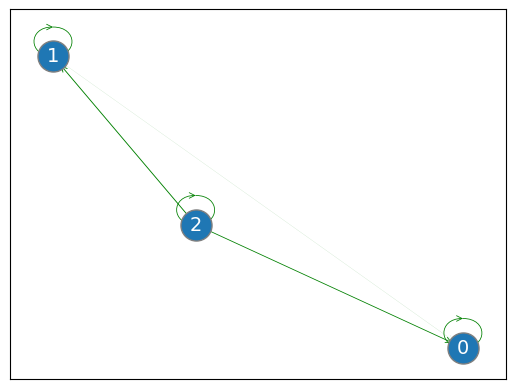

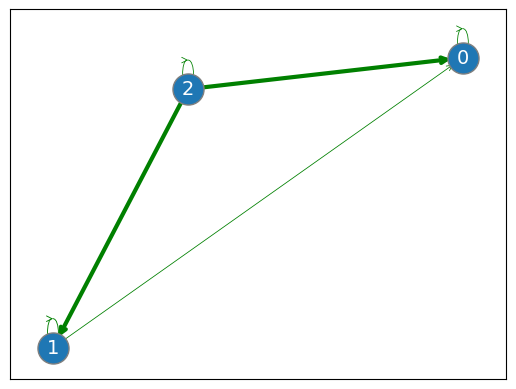

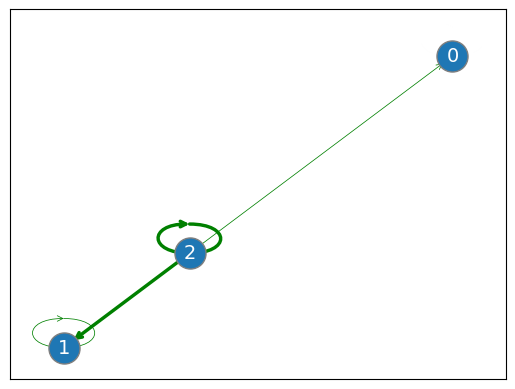

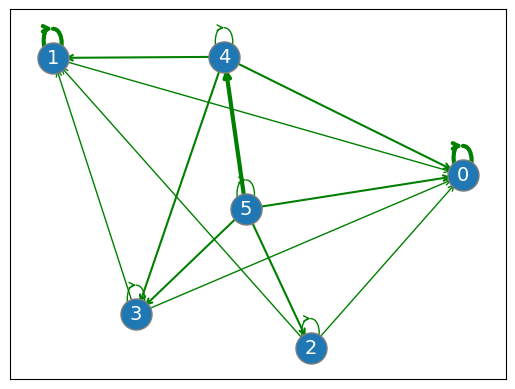

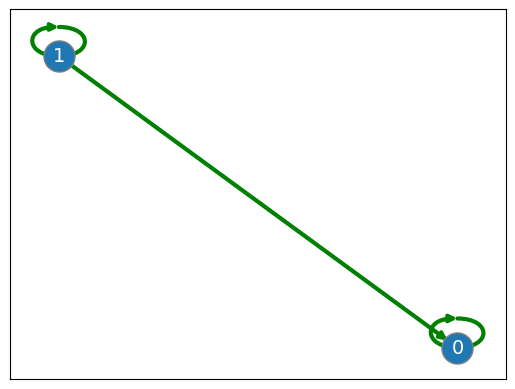

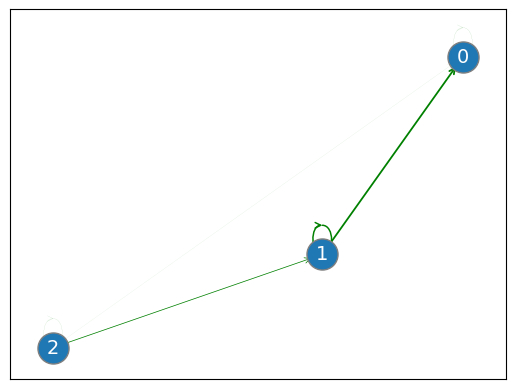

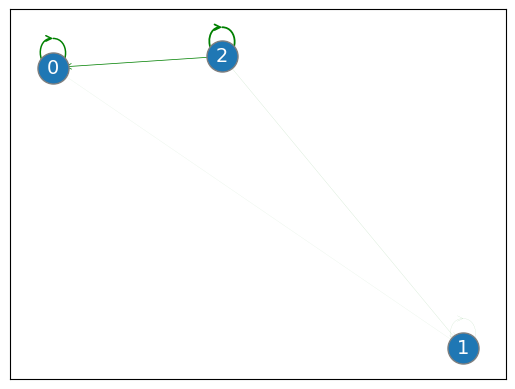

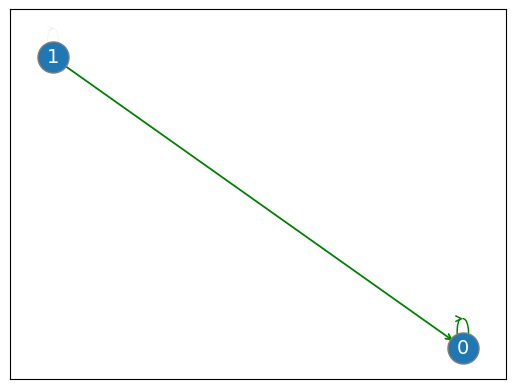

In [211]:
import networkx as nx

def get_edge_index(group):
    indices = group.index    
    offset = 0# indices[0]
    num_nodes = len(indices)
    edge_index = torch.zeros((2, sum(range(num_nodes + 1))), dtype=torch.long)+offset

    ## Self edges
    edge_index[:, 0:num_nodes] = (torch.arange(num_nodes) + offset).view(1, -1)
    idx = num_nodes
    for i in range(1, num_nodes):
        edge_index[1, idx:idx + i] = i+offset
        edge_index[0, idx:idx + i] = torch.arange(i)+offset
        idx += i
    return edge_index

edge_len = 0
edge_thickness_scale = 3
options = {"edgecolors": "tab:gray", "node_size": 500}

counter = 0
for Id, group in data.groupby(["Id"]):
    
    
    edge_index = get_edge_index(group)
    edge_len += edge_index[0].shape[0]
    if group.shape[0] == 1:
        continue
    G = nx.DiGraph()
    
    group_reset = group.reset_index(drop=True)
    sepsis_nodes = group_reset[group_reset["Label"] == 1]
    control_nodes = group_reset[group_reset["Label"] == 0]
    
    

    last_layer = 1
    attention_heads = 1
    weights = attention_w[last_layer][attention_heads][edge_len-edge_index[0].shape[0]:edge_len]
    for i in range(len(edge_index[0])):
        source_edge = edge_index[0][i]
        target_edge = edge_index[1][i]
        G.add_edge(source_edge.item(),target_edge.item(),color='g',weight=weights[i].item())
    
    
    pos = nx.spring_layout(G)
    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]
    weights = [G[u][v]['weight']*edge_thickness_scale for u,v in edges]
    
    control_labels= {i: i for i in control_nodes.index}
    sepsis_labels= {i: i for i in sepsis_nodes.index}
    nodes = nx.draw_networkx_nodes(G, pos, control_labels, node_color="tab:blue", **options)
    nodes = nx.draw_networkx_nodes(G, pos, sepsis_labels, node_color="tab:red", **options)
    nx.draw_networkx_labels(G,pos,control_labels,font_size=14,font_color='w')
    nx.draw_networkx_labels(G,pos,sepsis_labels,font_size=14,font_color='w')
    edges = nx.draw_networkx_edges(
        G,
        pos,
        arrowstyle="->",
        arrowsize=10,
        edge_color=colors,
        width=weights
    )
    plt.show()
    counter+=1
    if counter ==10:
        break